# Нейронная сеть прямого распространения — классификация
Полносвязная сеть вычисляет последовательность аффинных преобразований и нелинейностей: $h^{(l)} = \sigma(W^{(l)} h^{(l-1)} + b^{(l)})$. Для классификации используется softmax $P(y=k|x)=\frac{e^{z_k}}{\sum_j e^{z_j}}$ и кросс-энтропия $\mathcal{L}=-\sum_k y_k \log P(y=k|x)$. Обучение — минимизация функции потерь методом градиентного спуска (backpropagation).


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `load_breast_cancer`, `train_test_split`, `StandardScaler`, `Pipeline`, `MLPClassifier`, метрики классификации.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [11]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
HEATMAP_CMAP = "coolwarm"
CONFUSION_CMAP = "Blues"


## Датасет: описание и частичная распечатка
Датасет **Breast Cancer Wisconsin** — 569 пациентов, 30 числовых признаков. Задача — бинарная классификация опухолей (злокачественная / доброкачественная). Нейросеть использует сложные нелинейные взаимодействия между признаками, которые линейные модели пропускают. Сравнительно небольшой датасет полезен для демонстрации MLPClassifier без переобучения.


In [12]:
breast = load_breast_cancer(as_frame=True)
data = breast.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Предварительная обработка
Разделяем признаки и метки, стратифицированный train/test split (80/20). `StandardScaler` критически важен для нейросетей: метод градиентного спуска сходится значительно медленнее при разных масштабах признаков — градиенты по одним весам будут огромными, по другим — ничтожными.


In [13]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


## Тепловая карта корреляций
Матрица из 31 переменной. Нейросеть, в отличие от линейных моделей, не страдает от мультиколлинеарности — она сама учится находить нужные комбинации признаков. Тем не менее тепловая карта помогает понять структуру данных и выбрать число нейронов.


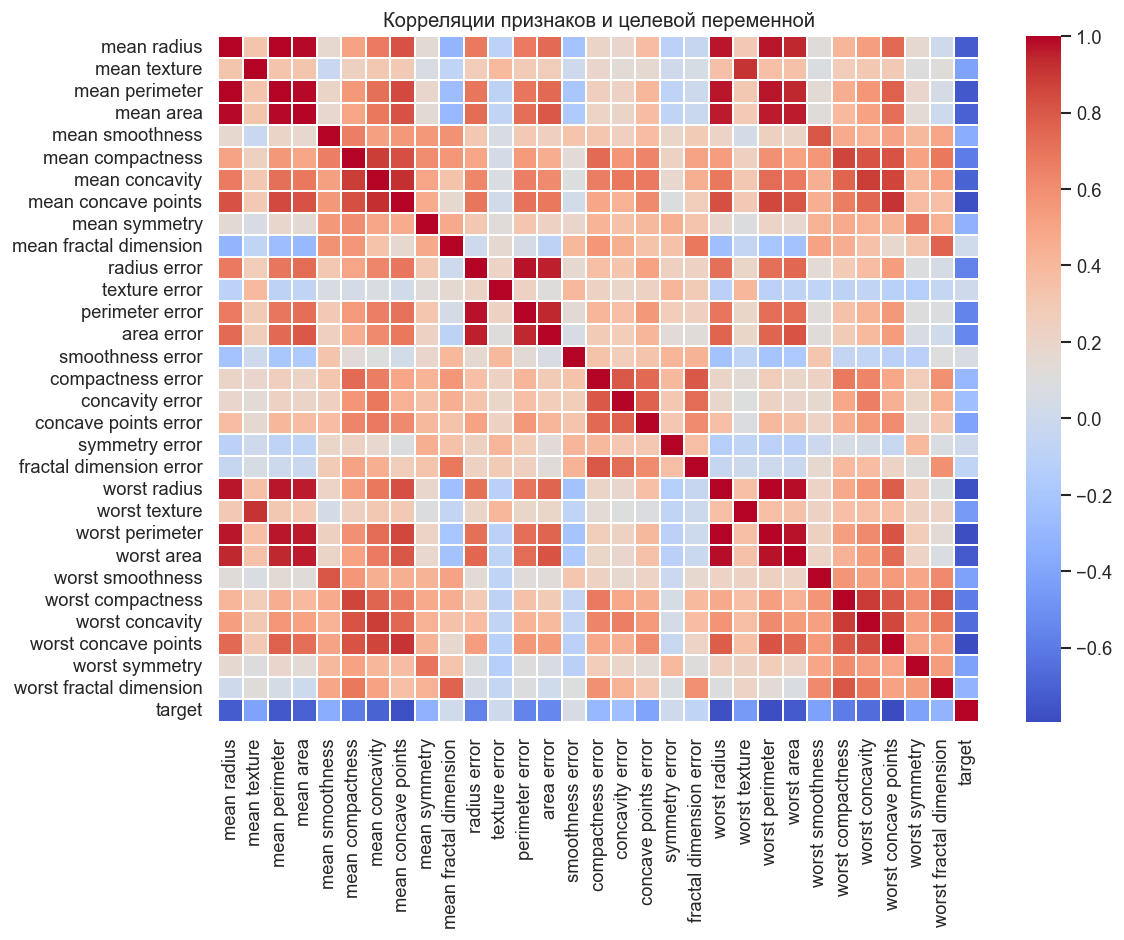

In [14]:
plt.figure(figsize=(10, 8))
correlation = data.corr()
sns.heatmap(correlation, cmap=HEATMAP_CMAP, linewidths=0.2)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
`MLPClassifier(hidden_layer_sizes=(64, 32))` — два скрытых слоя с 64 и 32 нейронами и активацией ReLU. `max_iter=500` — максимальное число эпох. Используем оптимизатор Adam (по умолчанию `solver='adam'`). Нейросеть обучается итерационно, постепенно уменьшая кросс-энтропийные потери через backpropagation.


In [15]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            max_iter=500,
            random_state=42,
        )),
    ]
)
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500,
                               random_state=42))])

## Прогнозы модели
Метрики на тестовой выборке:
- **Accuracy** — ожидаем >97% для нейросети на этом датасете;
- **Precision/Recall/F1** — важны особенно для FN (пропущенные злокачественные случаи).

Нейросеть должна превзойти одиночное дерево решений и быть сравнима с Random Forest.


In [16]:
y_pred = model.predict(X_test)

print("MLP Classifier Metrics")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1:        {f1_score(y_test, y_pred):.3f}")


MLP Classifier Metrics
Accuracy:  0.965
Precision: 0.986
Recall:    0.958
F1:        0.972


## Графики выходных результатов
**График 1. Матрица ошибок.** Ожидаем минимальные внедиагональные значения. FN (правый нижний — предсказан доброкачественный, реально злокачественный) — наиболее критичная ошибка.

**График 2. Кривая обучения (Loss Curve).** Показывает, как снижается кросс-энтропия по эпохам. Монотонное убывание — нормальная сходимость. Плато указывает, что модель остановилась; «пила» означает слишком большой learning rate. Число итераций, при котором кривая выравнивается, — ориентир для `max_iter`.


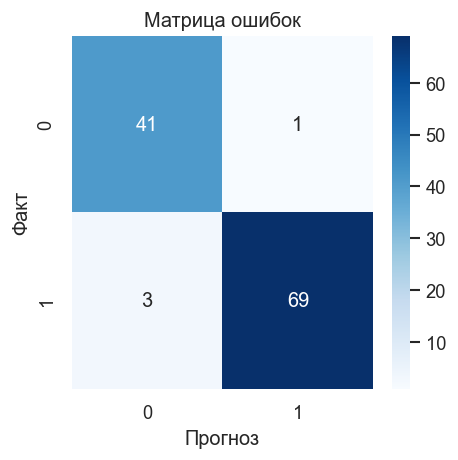

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=CONFUSION_CMAP)
plt.title("Матрица ошибок")
plt.xlabel("Прогноз")
plt.ylabel("Факт")
plt.tight_layout()
plt.show()


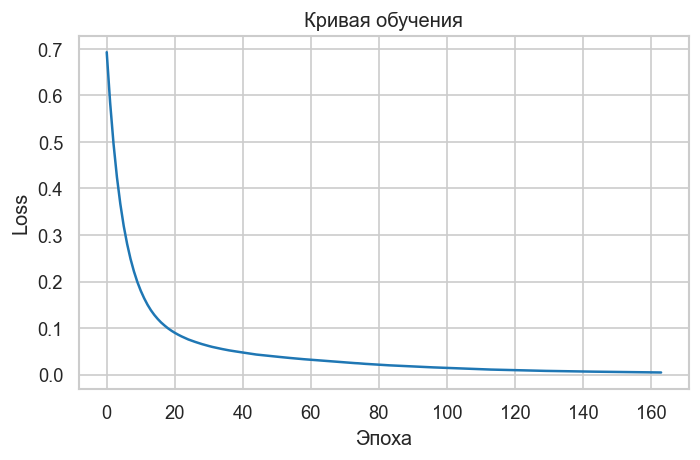

In [18]:
loss_curve = model.named_steps["mlp"].loss_curve_
plt.figure(figsize=(6, 4))
plt.plot(loss_curve, color=PRIMARY_COLOR)
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Кривая обучения")
plt.tight_layout()
plt.show()
